In [1]:
import aipy
import healpy as hp
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import os
from pygdsm import GlobalSkyModel

In [2]:
def z_to_nu(z):
    nu_0 = 1420405751.768  # Hz
    return nu_0 / (z+1)

In [3]:
redshifts = np.loadtxt('z_EIGSEP.txt')
freqs = z_to_nu(redshifts) / 1e9  # GHz

In [4]:
NSIDE = 64
hpb = aipy.healpix.HealpixBase(nside=NSIDE)
I_sky = np.empty((freqs.size, hpb.npix()))
gsm = GlobalSkyModel(freq_unit='GHz')
ga2eq = aipy.coord.convert_m('ga', 'eq')
for ch,f in enumerate(freqs):
    if NSIDE == 512:
        I_sky[ch] = gsm.generate(f)
    else:
        I_sky[ch] = hp.ud_grade(gsm.generate(f), nside_out=NSIDE)

In [5]:
NTIMES = 256
JD = 2459117
jds = np.linspace(JD, JD+1, NTIMES)

crd_eq = np.array(hpb.px2crd(np.arange(hpb.npix())))
antpos = np.array([[0.,0,0]]) # meters
loc = ('40:00', '0:00')
aa = aipy.amp.AntennaArray(loc, antpos)

eq2tops = []
for jd in jds:
    aa.set_jultime(jd)
    eq2tops.append(np.dot(aa.eq2top_m, ga2eq))
eq2tops = np.array(eq2tops)

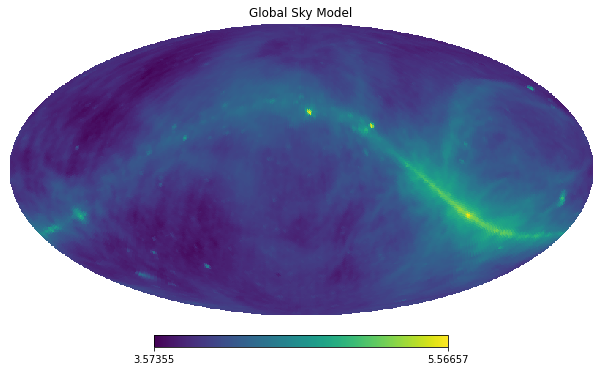

In [6]:
rot=hp.Rotator(coord=['G','C'])
hp.mollview(np.log10(rot.rotate_map_pixel(I_sky[-1])), rot=[0,30,0], title='Global Sky Model')
#plt.savefig('plots/gsm.png', bbox_inches='tight')

In [8]:
THETA_AXIS = 0
PHI_AXIS = 1
VOLT_AXIS = 2
freqs = np.array([float(f.split()[1][3:-1]) for f in beamfiles]) / 1000 # GHz
thetas, phis = np.loadtxt(beamfiles[0], skiprows=2, usecols=(THETA_AXIS,PHI_AXIS)).T
thetas = np.deg2rad(np.unique(thetas))
phis = np.deg2rad(np.unique(phis))
data = np.array([np.loadtxt(f, skiprows=2, usecols=VOLT_AXIS) for f in beamfiles])
data.shape = (-1, phis.size, thetas.size)

NameError: name 'beamfiles' is not defined

In [7]:
if not os.path.exists('auto.npz'):
    #from hera_gpu.vis import vis_gpu as vis
    from hera_sim.visibilities.vis_cpu import vis_cpu as vis

    data = np.empty((NTIMES,freqs.size), dtype=np.complex64)
    for ch in range(freqs.size):
        print(ch)
        data[:,ch] = vis(antpos, freqs[ch], eq2tops, crd_eq, I_sky[ch], beams[ch:ch+1])[:,0,0]
    np.savez('auto.npz', data=data, freqs=freqs, jds=jds)
else:
    print('Reading from file')
    npz = np.load('auto.npz')
    data = npz['data']
    jds = npz['jds']
    freqs = npz['freqs']

/home/christian/EIGSEP/eigsep_misc/analysis_venv/lib/python3.8/site-packages/hera_sim/adjustment.py:29: UserWarning: git is not installed. Rephasing tool unavailable.
  warn(f"{missing} is not installed. Rephasing tool unavailable.")


0


NameError: name 'beams' is not defined

NameError: name 'idata' is not defined

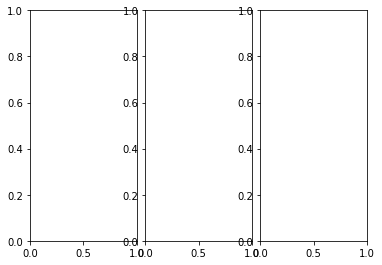

In [20]:
fig = plt.figure()
h_gap = 0.04
axarr=[fig.add_axes([0.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([.8/3+.1, 0.2, .8/3-h_gap/2, .8]), fig.add_axes([2*.8/3+.1, 0.2, .8/3-h_gap/2, .8])]

plt.sca(axarr[0])
#plt.text(85, 0.6, '$\\times 10^{-3}$', color='k', fontsize=14)
#plt.text(55, 0.23, '$\\times 10^{-3}$', color='r', fontsize=14)

l0=plt.plot(freqs * 1e3, np.abs(idata[::50] - reor).T/1e4, color='r', lw=1, ls='-')[0]
l1=plt.plot(freqs * 1e3, np.abs(idata_dish[::50] - reord).T/1e4, color='k', lw=1, ls='-')[0]

#l2=plt.semilogy(freqs * 1e3, np.abs(idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor), color='r', lw=4)[0]
#l3=plt.semilogy(freqs * 1e3, np.abs(idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor), color='k', lw=4)[0]
l2=plt.plot(freqs * 1e3, models.T[:, ::10], lw=1, alpha=.5, color='grey')[0]
l3=plt.plot(freqs * 1e3, fake_eor, color='orange', lw=4)[0]
l5 = plt.plot(freqs*1e3, models[895], lw=2, color='purple')[0]
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vu[m] @ idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e2, color='r', lw=1)
#    plt.plot(freqs * 1e3, Vu[m]*2, color='r', lw=1)

    
#for m in range(3):
    #plt.plot(freqs * 1e3, (Vud[m] @ idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord)*Vud[m] / 1e2, color='k', lw=1)
#    plt.plot(freqs * 1e3, Vud[m]*2, color='k', lw=1)

    
summed = np.zeros_like(freqs,dtype=complex)
#for m in range(3):
#    summed+=Vu[m] @ (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor)*Vu[m] / 1e4
#plt.plot(freqs*1e3, summed, ls='--', color='r')
    

#l5=plt.semilogy(freqs * 1e3, np.abs(2.73/10+fake_eor), color='orange', ls=':', lw=4)[0]

plt.ylim(-.6, 1)
#l7=plt.plot(freqs * 1e3, np.abs(idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint), color='green', ls='--', lw=4)[0]

plt.ylabel('|T| [K]', fontsize=18)
plt.grid()
#plt.ylim(1e-3, 5e3)
plt.xlim(55, 245)
plt.gca().tick_params(labelsize=16)
plt.xlabel("$\\nu$ [MHz]", fontsize=18)


plt.sca(axarr[2])
plt.semilogy(np.abs(np.dot(V, rmodels.T))[:, ::50], lw=1, alpha=.5, color='grey')
x = np.abs(np.dot(V, (idata_flattened[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T))
threshold_fg = np.where(x < x.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(V.T @ np.diag(np.abs((idata[np.argmin(np.mean(idata_flattened, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ V))

#plt.semilogy(np.abs(np.dot(Vd, (idata[np.argmin(np.mean(idata_flattened, axis=1))] - reor).T)),
#             'r', lw=4)[0]
l0=plt.semilogy(x, 'r-', lw=4)[0]
plt.semilogy(np.abs(np.dot(V, reor)),color='orange', lw=4)
l4=plt.semilogy(noise_level, color='green', ls='--', lw=4)[0]
plt.semilogy(np.abs(V @ rmodels[895]), lw=2, color='purple')

#index_tm4 = np.argmin(np.dot(V, ))
#plt.axvline(threshold_fg, color='r', ls='--')
plt.grid()
#plt.gca().set_xticklabels([])
plt.gca().tick_params(labelsize=16)
plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
plt.xlabel('Foreground Eigenmode', fontsize=18)
#plt.gca().set_yticklabels([])
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position('right')
plt.ylabel('|T| [K]', fontsize=18)



plt.sca(axarr[1])
#plt.semilogy(np.abs(np.dot(Vd, )))
l3=plt.semilogy(np.abs(np.dot(Vd, rmodelsd.T))[:, ::50], lw=1, alpha=.5, color='grey')[0]
xd = np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T))
threshold_fg_d = np.where(xd < xd.max()*1e-4)[0].min()
noise_level = np.sqrt(np.diag(Vd.T @ np.diag(np.abs((idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))]) / np.sqrt(DF * 1e9 * tint)) ** 2.) @ Vd))

#l0=plt.semilogy(np.abs(np.dot(Vd, (idata_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
#             'k', lw=4)[0]
l1=plt.semilogy(np.abs(np.dot(Vd, (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reord).T)),
             'k-', lw=4)[0]
l3=plt.semilogy(np.abs(np.dot(Vd, reord)),color='orange', lw=4, ls='-')[0]
plt.semilogy(np.abs(Vd @ rmodelsd[895]), lw=2, color='purple')
#l2=plt.semilogy(freqs * 1e3, np.abs(Vd @ (idata_flattened_dish[np.argmin(np.mean(idata_flattened_dish, axis=1))] - reor) / np.sqrt(DF * 1e9 * tint)), color='green', ls='--', lw=4)[0]
plt.semilogy(noise_level, color='green', ls='--', lw=4)


plt.grid()
plt.gca().tick_params(labelsize=16)
#plt.axvline(threshold_fg_d, color='r', ls='--')

plt.ylim(1e-3, 5e3)
plt.xlim(0,45)
#plt.gca().set_xticklabels([])
plt.xlabel('Foreground Eigenmode', fontsize=18)
plt.gca().set_yticklabels([])

threshold_21cm = np.where(np.abs(np.sqrt(np.abs(Sm)) < .1 * np.sqrt(np.abs(Sm)).max()))[0].min()
threshold_21cmd = np.where(np.abs(np.sqrt(np.abs(Smd)) < .1 * np.sqrt(np.abs(Smd)).max()))[0].min()



plt.gcf().set_size_inches(14, 6)


fig.legend((l0,l1,l3, l5,l2, l4), ('Vivaldi Foregrounds', 'Dish Foregrounds', 'EDGES 21cm', 'Nominal 21cm', 'Other 21cm', 'Thermal Noise'), loc='lower center' ,ncol=6, fontsize=12)


plt.savefig('plots/pc_plot_w_frequency.png', bbox_inches='tight')